In [22]:
%cd dialogue_sim

/home/kirill/Desktop/DGAC/dialogue_sim


In [33]:
import pandas as pd
import numpy as np
from subgraph.datasets import multiwoz
from minicache import cached_step, init, MetadataStorage, Cache
from dialogue_sim.utils import plot_pairwaise_class
import numpy as np
import seaborn as sns
import scipy

sns.set_theme(style = 'darkgrid', font_scale = 1.5)
init(meta=MetadataStorage(), cache=Cache())

Cache for init not found, caclulating...
Done


In [23]:
%reload_ext autoreload
%autoreload 2

In [24]:
import pickle

with open("data/mwtrain_sbert.pkl", "rb") as file:
    train_dials = pickle.load(file)

with open("data/mwtest_sbert.pkl", "rb") as file:
    test_dials = pickle.load(file)

num_clusters = 61

In [44]:
def get_sim_matrix(dial1, dial2):
    return dial1.lm_embeddings @ dial2.lm_embeddings.T

def opt_match_score(dial1, dial2):
    matrix = get_sim_matrix(dial1, dial2)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(matrix, maximize = True)
    return matrix[row_ind, col_ind].mean()

def diag_score(dial1, dial2):
    return np.diag(get_sim_matrix(dial1, dial2)).mean()

opt_match_score(train_dials[0], train_dials[1])

0.4063665

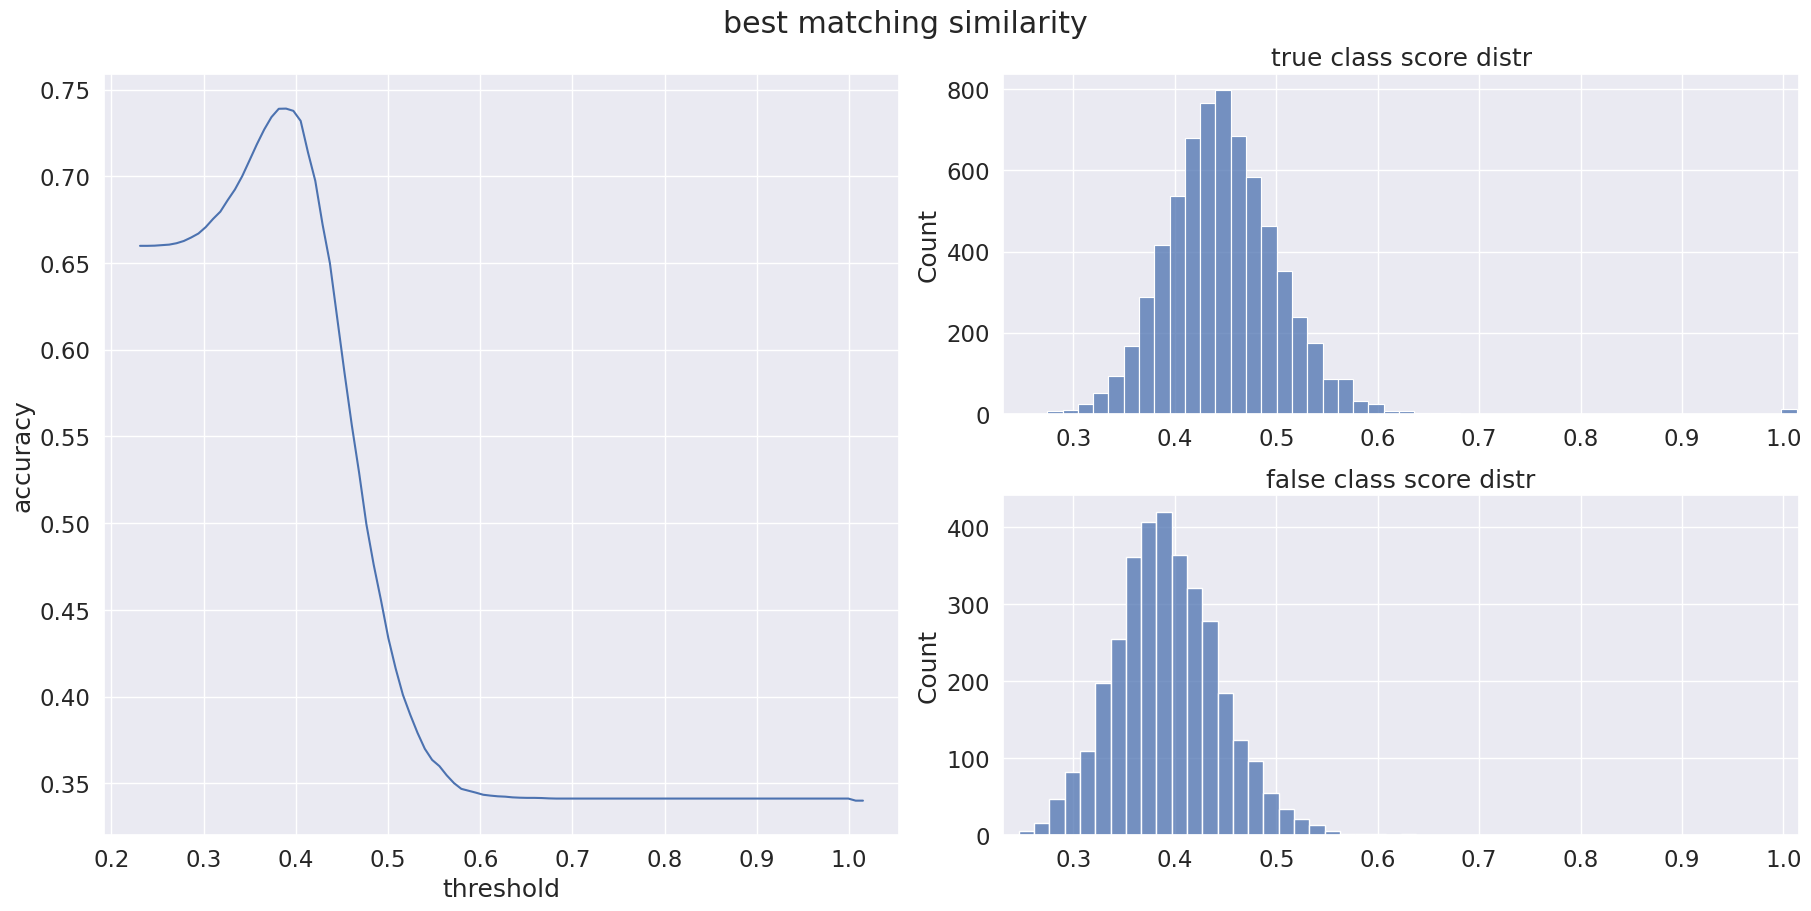

max acc: 0.739
class 1 prop : 0.6599
auc :  0.7727


In [47]:
from dialogue_sim.utils import plot_pairwaise_class
from dialogue_sim.sim_metrics import mean_first_stage_emb
from sklearn.metrics import roc_auc_score


def service_classification_metrics(sim_metric, test_data, num_repeats = 1000):
    n_dialogues = len(test_data)
    idxs = np.random.choice(range(n_dialogues), size = (num_repeats, 2))
    dialogues = [(test_data[i], test_data[j]) for (i, j) in idxs]
    services = [(dial[0].services, dial[1].services) for dial in dialogues]
    target = np.array([len(set(serv[0]) & set(serv[1])) > 0 for serv in services]).astype('int')
    #target = np.array([set(serv[0]) == set(serv[1]) for serv in services]).astype('int')
    scores = []
    for i in range(num_repeats):
        metric = sim_metric(*dialogues[i])
        scores.append(metric)
    scores = np.array(scores)
    return roc_auc_score(target, scores), scores, target

auc, scores, target = service_classification_metrics(opt_match_score, test_dials, 10000)
max_acc = plot_pairwaise_class(scores, target, "best matching similarity")
print(f'auc : {auc : .4f}')

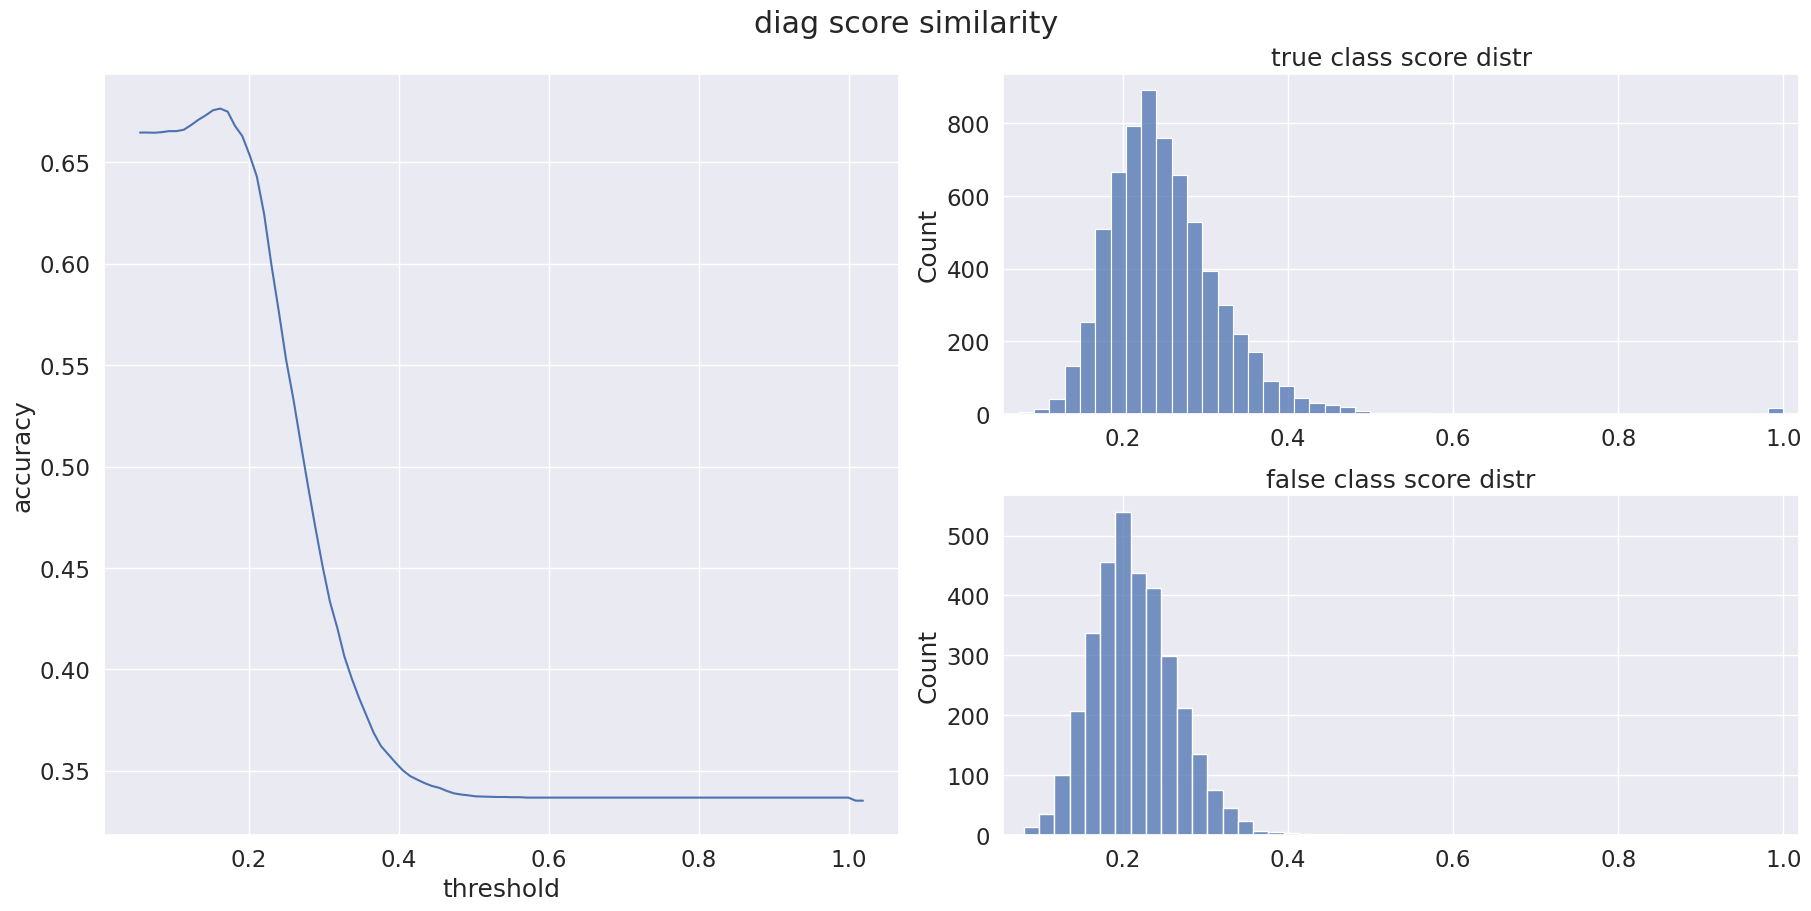

max acc: 0.676
class 1 prop : 0.6647
auc :  0.6636


In [48]:
auc, scores, target = service_classification_metrics(diag_score, test_dials, 10000)
max_acc = plot_pairwaise_class(scores, target, "diag score similarity")
print(f'auc : {auc : .4f}')

In [52]:
def select_similar(target_dial, dials, metric, thresh):
    res = []
    for i, dial in enumerate(dials):
        sim = metric(target_dial, dial)
        if sim > thresh:
            res.append(i)
    return np.array(res)

sim_dials = select_similar(train_dials[0], train_dials, opt_match_score, 0.39)

In [57]:
%cd ..

/home/kirill/Desktop/DGAC


In [60]:
from embedders import CachedEmbeddings
from dgac import dgac_two_stage

train, test = multiwoz()

EMB_PATH = 'embeddings/multiwoz/sentence_bert_{split}_embeddings.npy'
CONV_EMB_PATH = 'embeddings/multiwoz/{split}_convert_context.np.npy'

train_emb = np.load(EMB_PATH.format(split = 'train'))
test_emb = np.load(EMB_PATH.format(split = 'test'))

conv_train_emb = np.load(CONV_EMB_PATH.format(split = 'train'))
conv_test_emb = np.load(CONV_EMB_PATH.format(split = 'test'))

embedder = CachedEmbeddings(
    dialogues=train,
    embeddings=train_emb,
    test_dialogues=test,
    test_embeddings=test_emb
)
conv_embedder = CachedEmbeddings(
    dialogues= train,
    embeddings= conv_train_emb,
    test_dialogues= test,
    test_embeddings= conv_test_emb
)

Using cached "multiwoz"


In [63]:
from dataset import Subset

train_selected = Subset(train, sim_dials)

  0%|          | 0/5797 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



  0%|          | 0/5797 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

  0%|          | 0/1326 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



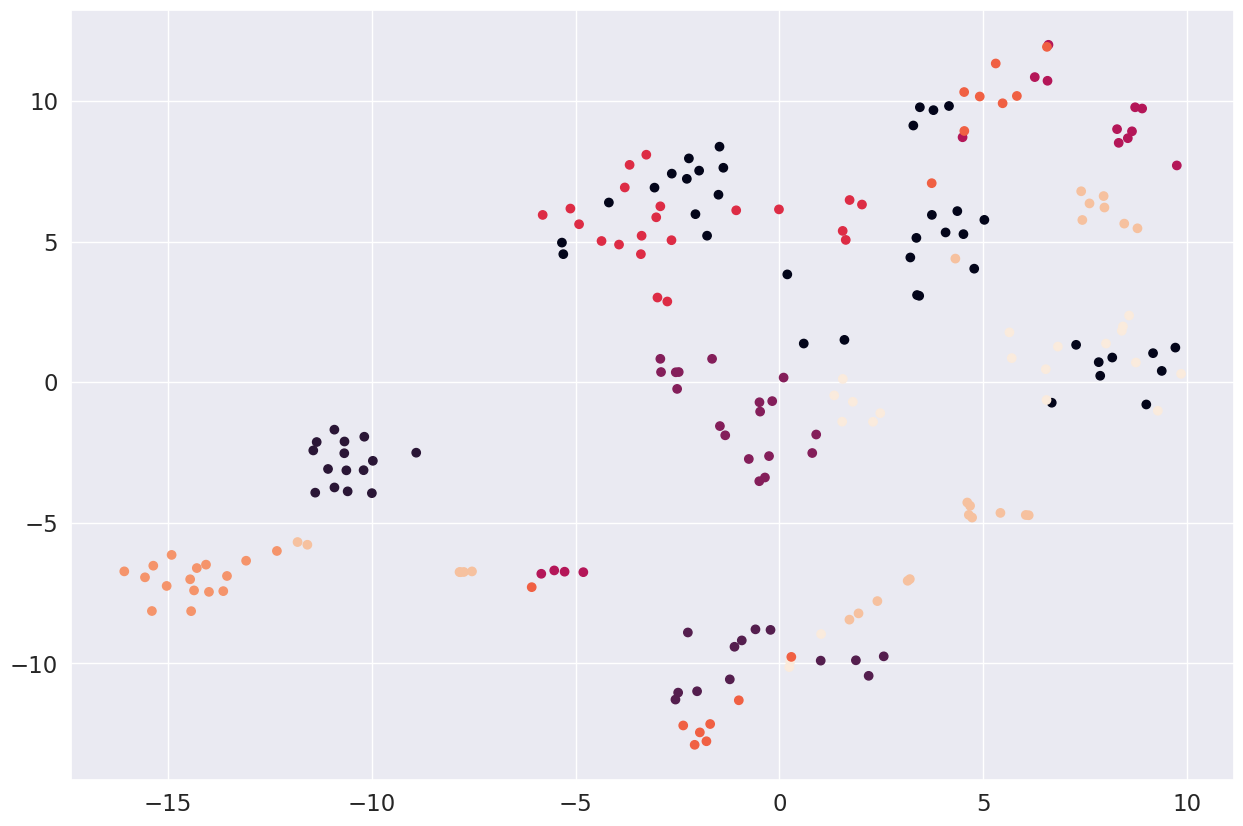

In [80]:
import pickle
from dgac import dgac_two_stage

sbert_subgraph_10 = dgac_two_stage(train_selected, embedder, n_clusters_first_stage = {"SYSTEM" : 100, "USER"  : 100},
                            n_clusters={"SYSTEM" : 5, "USER" : 5}, verbosity=-1)

In [81]:
with open('dialogue_sim/graphs/selected_sbert_10.pkl', 'wb') as file:
    pickle.dump(sbert_subgraph_10, file)

In [77]:
train_dials[0].str

"i need a place to dine in the center thats expensive.I have several options for you; do you prefer African, Asian, or British food?.Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation?.There is an Afrian place named Bedouin in the centre. How does that sound?.Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel?.Bedouin's phone is 01223367660. As far as hotels go, I recommend the University Arms Hotel in the center of town..Yes. Can you book it for me?.Sure, when would you like that reservation?.i want to book it for 2 people and 2 nights starting from saturday..Your booking was successful. Your reference number is FRGZWQL2 . May I help you further?.That is all I need to know. Thanks, good bye..Thank you so much for Cambridge TownInfo centre. Have a great day!."